<a href="https://colab.research.google.com/github/WhiteBeyond/AI/blob/main/test_weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#import libs
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [3]:
#prepare data
weather = pd.read_csv('/content/drive/MyDrive/Weather/HCM.csv', index_col='datetime')

<Axes: >

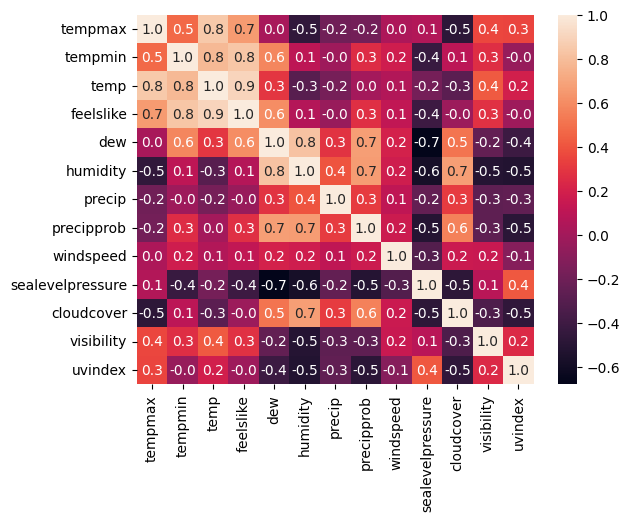

In [4]:
#specifile some index for correlation
correlation_weather = weather[['tempmax','tempmin','temp','feelslike','dew', 'humidity', 'precip', 'precipprob',
                               'windspeed', 'sealevelpressure', 'cloudcover','visibility','uvindex'
                               ]].copy()
correlation = correlation_weather.corr()
sns.heatmap(correlation, annot = True, annot_kws={"ha": 'center'}, fmt='.1f' )

In [5]:
core_weather = weather[['tempmax','tempmin','temp','feelslike','humidity','precip', 'precipprob', 'preciptype',
                        'windspeed', 'sealevelpressure', 'cloudcover','visibility','uvindex','sunrise', 'sunset', 'conditions'
                      ]].copy()


In [6]:
#replace NaN to '0' 
core_weather["preciptype"] = core_weather["preciptype"].fillna(0)
core_weather["preciptype"].replace({"rain": "1"}, inplace=True)
c_weather = core_weather.copy()

In [7]:
#convert index to datetime for better search 
core_weather.index = pd.to_datetime(core_weather.index)
c_weather.index = pd.to_datetime(c_weather.index)

In [8]:
target_vars = ['tempmax', 'tempmin', 'temp', 'humidity', 'precip', 'windspeed', 'sealevelpressure', 'visibility', 'uvindex']
target_vars

['tempmax',
 'tempmin',
 'temp',
 'humidity',
 'precip',
 'windspeed',
 'sealevelpressure',
 'visibility',
 'uvindex']

In [9]:
for t in target_vars:
    core_weather[f"target_{t}"] = core_weather.shift(-1)[t]

core_weather = core_weather.iloc[:-1,:].copy()

In [10]:
#train model
reg = Ridge(alpha=.1)

In [11]:
#choose predictors to predict data 
predictors = c_weather.columns[~c_weather.columns.isin(["feelslike","precipprob","preciptype", "cloudcover", "sunrise", "sunset", "conditions"])]
predictors

Index(['tempmax', 'tempmin', 'temp', 'humidity', 'precip', 'windspeed',
       'sealevelpressure', 'visibility', 'uvindex'],
      dtype='object')

In [12]:
train = core_weather.loc[:"2022-12-31"]
test = core_weather.loc["2023-01-01":]

In [23]:
import pickle
predictions = {}
results_df = pd.DataFrame()
error_df = pd.DataFrame()
reg_models = {}
for t in target_vars:
  predictors_sub = predictors
  reg.fit(train[predictors_sub], train[f"target_{t}"])
  reg_models[t] = reg
  predictions[t] = reg.predict(test[predictors_sub])
  error = mean_squared_error(test[f"target_{t}"], predictions[t])
  result = pd.DataFrame({f"actual_{t}": test[f"{t}"], f"pred_{t}": predictions[t]})
  results_df = pd.concat([results_df, result], axis=1)
  error_result = pd.DataFrame({"error": error}, index=[f"error_{t}"])
  error_df = pd.concat([error_df, error_result])
# Save the dictionary of regression models to a file
  with open(f'reg_models_{t}.pkl', 'wb') as file:
      pickle.dump(reg_models, file)

In [24]:
errors = {}

# Iterate through each target variable and extract the corresponding error value
for t in target_vars:
    error_value = error_df.loc[f"error_{t}", "error"]
    errors[t] = error_value
errors

{'tempmax': 1.2710376234156706,
 'tempmin': 0.926438594268757,
 'temp': 0.3450867745833199,
 'humidity': 23.752391904240802,
 'precip': 16.0454375272414,
 'windspeed': 10.103956952667716,
 'sealevelpressure': 0.63937578011907,
 'visibility': 0.3081590851062581,
 'uvindex': 1.7398087131599589}

In [25]:
import numpy as np
future_dates = pd.date_range(start="2023-05-1", periods=30)
predictions_df = pd.DataFrame(index=future_dates)
future_data = pd.DataFrame(index=future_dates, columns=predictors)
past_data = core_weather.loc[: "2022-12-31"]

for i, date in enumerate(future_dates):
    same_day_data = past_data[past_data.index.dayofyear == date.dayofyear]  # Filter past data for the same day
    average_data = same_day_data.mean()
    random_noise = {var: np.random.normal(0, np.sqrt(errors[var])) for var in errors}
    future_data.loc[date] = average_data[predictors].values + list(random_noise.values())  # Convert dict_values to list

future_data

<ipython-input-25-84183d869809>:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  average_data = same_day_data.mean()
<ipython-input-25-84183d869809>:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  average_data = same_day_data.mean()
<ipython-input-25-84183d869809>:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this 

,tempmax,tempmin,temp,humidity,precip,windspeed,sealevelpressure,visibility,uvindex
2023-05-01,32.576426,26.926652,30.460447,75.062157,1.526431,23.072938,1009.0349,9.874822,8.104144
2023-05-02,34.059025,25.758036,30.528682,65.713804,4.77877,22.159149,1007.431565,9.918938,7.614291
2023-05-03,34.82182,27.022083,29.04092,84.620517,3.927763,19.367451,1009.637026,10.887018,6.377202
2023-05-04,37.062906,26.060891,29.633562,69.014851,7.687632,11.960779,1008.277228,10.481516,10.260728
2023-05-05,36.679138,27.158144,29.780155,75.686907,-3.594529,16.50306,1008.836905,9.696436,8.055752
2023-05-06,37.37901,26.876848,30.918524,67.620159,0.635842,18.581947,1008.623491,10.325529,7.419581
2023-05-07,36.67505,28.728135,30.923182,78.261864,1.888542,22.959754,1007.512607,10.131068,5.81971
2023-05-08,34.935012,27.252202,31.179313,83.762292,0.084377,19.552083,1006.603692,9.415115,6.37793
2023-05-09,34.91683,29.057799,28.882294,71.432714,1.17526,17.499182,1007.78138,9.914422,6.304061
2023-05-10,34.03844,25.440736,30.877261,71.638067,1.155476,16.009937,1007.351922,9.742055,6.972591


In [26]:
# Iterate through each target variable
predictions_future = {}
results_future = pd.DataFrame(index=future_dates)
import pickle

# Load the saved regression models from file

for t in target_vars:
    with open(f'reg_models_{t}.pkl', 'rb') as file:
        reg_models = pickle.load(file)
    predictors_sub = predictors
    reg_future = reg_models[t]
    predictions_future = reg_future.predict(future_data[predictors_sub])
    results_future[f"pred_{t}"] = predictions_future
# Display the predicted values for future dates
results_future

,pred_tempmax,pred_tempmin,pred_temp,pred_humidity,pred_precip,pred_windspeed,pred_sealevelpressure,pred_visibility,pred_uvindex
2023-05-01,34.436155,27.299299,30.185943,75.160462,5.667009,21.714826,1008.790628,10.055497,7.605274
2023-05-02,34.393504,26.614125,29.860825,70.255288,6.674120,21.814223,1007.440687,10.063906,7.202661
2023-05-03,33.746695,26.075158,29.082369,83.252500,4.167158,19.265161,1009.479627,9.975685,6.957343
2023-05-04,34.610236,25.613916,29.364220,71.547174,2.303013,16.651466,1008.427795,9.918990,9.130408
2023-05-05,34.707174,26.151078,29.562665,75.727131,2.834078,17.492495,1008.806979,9.576648,7.953424
2023-05-06,35.435867,26.707943,30.264438,71.256449,4.051339,19.290855,1008.505338,10.013702,7.477607
2023-05-07,35.139129,27.603384,30.403470,79.504683,6.081388,21.561118,1007.489793,9.887046,6.462202
2023-05-08,34.892412,28.002619,30.678172,84.638325,10.265269,20.799835,1006.413785,9.612043,5.967199
2023-05-09,33.528966,25.712224,28.704289,71.724409,-0.395195,18.177875,1008.261589,9.692146,7.476359
2023-05-10,34.543436,26.972383,30.218693,75.473845,8.290720,19.266095,1007.171910,9.849333,6.408405
